In [2]:
pip install nltk

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, cosine_distances
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.stats import spearmanr

import plotly.express as px
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

import string

from sklearn.manifold import MDS

In [4]:
# load "Restaurants" sheet
Restaurants = pd.read_excel('Evanston Restaurant Reviews.xlsx', sheet_name='Restaurants')
Restaurants.columns = Restaurants.columns.str.replace(' ', '')
# check missing value in Restaurant 
Restaurants.isnull().sum()

RestaurantName      0
Cuisine             0
Latitude            0
Longitude           0
AverageCost         0
OpenAfter8pm?       0
BriefDescription    0
dtype: int64

In [5]:
# load "Reviews" sheet
Reviews = pd.read_excel('Evanston Restaurant Reviews.xlsx', sheet_name='Reviews')
Reviews.columns = Reviews.columns.str.replace(' ', '')
Reviews.isnull().sum()

ReviewerName                   0
RestaurantName                 0
Rating                         0
ReviewText                   563
DateofReview                   0
BirthYear                      2
MaritalStatus                 35
HasChildren?                  38
Vegetarian?                 1372
Weight(lb)                    97
Height(in)                    54
AverageAmountSpent             1
PreferredModeofTransport       4
NorthwesternStudent?           0
dtype: int64

# 1. Missing Value

In [6]:
# Check for duplicate rows
duplicate_rows = Reviews[Reviews.duplicated()]
print(f'Number of duplicate rows: {duplicate_rows.shape[0]}')

# Remove duplicate rows
Reviews = Reviews.drop_duplicates()

Number of duplicate rows: 8


In [7]:
Reviews.isnull().sum()

ReviewerName                   0
RestaurantName                 0
Rating                         0
ReviewText                   561
DateofReview                   0
BirthYear                      2
MaritalStatus                 35
HasChildren?                  38
Vegetarian?                 1365
Weight(lb)                    97
Height(in)                    54
AverageAmountSpent             1
PreferredModeofTransport       4
NorthwesternStudent?           0
dtype: int64

In [8]:
# Avoid duplicates due to letter case and spaces
Restaurants['RestaurantName'] = Restaurants['RestaurantName'].str.strip().str.lower()
Reviews['RestaurantName'] = Reviews['RestaurantName'].str.strip().str.lower()

# Convert both columns to sets for comparison
set_restaurants = set(Restaurants['RestaurantName'])
set_reviews = set(Reviews['RestaurantName'])

# Find names in set_restaurants that are not in set_reviews
differences_restaurants_not_in_reviews = set_restaurants - set_reviews

# Find names in set_reviews that are not in set_restaurants
differences_reviews_not_in_restaurants = set_reviews - set_restaurants

# Print the differences
print("Names in Restaurants not in Reviews:")
print(differences_restaurants_not_in_reviews)

print("\nNames in Reviews not in Restaurants:")
print(differences_reviews_not_in_restaurants)

Names in Restaurants not in Reviews:
set()

Names in Reviews not in Restaurants:
{"clare's korner", 'la principal', 'world market', 'todoroki sushi'}


In [9]:
# Connect "Cuisine" in the Restaurants CSV to the Reviews CSV
Reviews = pd.merge(Reviews, Restaurants[['RestaurantName', 'Cuisine']], on='RestaurantName', how='left')
#Reviews.head()

In [10]:
Reviews['RestaurantName'] = Reviews['RestaurantName'].replace({'clare\'s korner': 'claire\'s korner'}, regex=True)

# Update the 'Cuisine' column in the Reviews
cuisine_mapping = {
    'todoroki sushi': 'Japanese',
    'claire\'s korner': 'Jamaican',
    'la principal': 'Mexican'
}

for restaurant, cuisine in cuisine_mapping.items():
    Reviews.loc[Reviews['RestaurantName'] == restaurant, 'Cuisine'] = cuisine

# Remove the row with restaurant name 'world market' from Reviews
Reviews = Reviews[Reviews['RestaurantName'].str.lower() != 'world market']

In [57]:
len(Reviews['RestaurantName'].unique())

66

Since the cuisines of only 4 restaurants (todoroki sushi, clare's korner, la principal, world market) are missing, I chose to query the cuisines of each restaurant through Google Maps and fill the missing values ​​in the Cuisine column with this information. In addition, I found out that World Market in Evanston is a furniture store rather than a restaurant that specializes in catering services. Its existence may distort the recommendation system's analysis of restaurant reviews. Therefore, removing such irrelevant items can prevent the recommendation system from being disrupted and keep the recommended content relevant and focused.

In [12]:
#print(Reviews['MaritalStatus'].unique())
#print(Reviews['HasChildren?'].unique())
#print(Reviews['Vegetarian?'].unique())
#print(Reviews['AverageAmountSpent'].unique())
#print(Reviews['PreferredModeofTransport'].unique())
#print(Reviews['Cuisine'].unique())

# Avoid duplicates due to spelling and space
Reviews['MaritalStatus'] = Reviews['MaritalStatus'].str.strip().str.lower()
Reviews['MaritalStatus'] = Reviews['MaritalStatus'].replace({'widow': 'widowed'})

Reviews = Reviews.rename(columns={'Height(in)': 'Height(cm)'})

In [13]:
# missing categorical variables: ReviewText, MaritalStatus, HasChildren?, Vegetarian?, PreferredModeofTransport, AverageAmountSpent
Reviews['ReviewText'].fillna('No Review', inplace=True)
Reviews['MaritalStatus'].fillna('Unknown', inplace=True)
Reviews['HasChildren?'].fillna('Unknown', inplace=True)
Reviews['Vegetarian?'].fillna('Unknown', inplace=True)
Reviews['PreferredModeofTransport'].fillna('Unknown', inplace=True)
#Group by 'RestaurantName', and find the most frequently occurring 'AverageAmountSpent' value in each group to fill in missing
most_common_spent = Reviews.groupby('RestaurantName')['AverageAmountSpent'].apply(lambda x: x.value_counts().idxmax())
Reviews['AverageAmountSpent'] = Reviews.apply(
    lambda row: most_common_spent[row['RestaurantName']] if pd.isnull(row['AverageAmountSpent']) else row['AverageAmountSpent'],
    axis=1
)

/var/folders/zq/30b7r3ls663fyxrjrfv4l0km0000gn/T/ipykernel_1618/2997582244.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Reviews['ReviewText'].fillna('No Review', inplace=True)
/var/folders/zq/30b7r3ls663fyxrjrfv4l0km0000gn/T/ipykernel_1618/2997582244.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values

For categorical variables (e.g. MaritalStatus, HasChildren?, Vegetarian?, PreferredModeofTransport), I chose to fill missing values with 'Unknown'. I think in recommendation systems, users may not be willing or able to provide all the information. Marking these values with 'Unknown' preserves the integrity of the data and allows the recommendation algorithm to take these unknown situations into account. Additionally it avoids introducing some potential biases.

For the missing ReviewText, I chose to fill it in with 'No Review'. This shows that users did not leave comments, which is a direct reflection of the actual situation of the original data. In recommender systems, review text may be used to understand user preferences or for sentiment analysis, so retaining this information helps maintain the quality of the analysis.

For AverageAmountSpent, I chose to calculate the most frequently occurring spending level ('Low', 'Medium', 'High') per restaurant and use this to fill in missing values within the same restaurant. This reflects general consumer trends for each restaurant customer segment. In recommender systems, this can serve as an indicator of user preferences and possible spending power, thus helping to generate more personalized recommendations.


In [14]:
#print(Reviews['BirthYear'].unique())
#print(Reviews['Height(cm)'].unique())
#print(Reviews['Weight(lb)'].unique())

In [15]:
# missing numeric variables: BirthYear, Weight(lb), Height(in)
#Group by 'RestaurantName', and find mean of each numeric variables in each group to fill in missing
Reviews['BirthYear'] = Reviews.groupby('Cuisine')['BirthYear'].transform(lambda x: x.fillna(x.median()))
Reviews['Weight(lb)'] = Reviews.groupby('Cuisine')['Weight(lb)'].transform(lambda x: x.fillna(x.median()))
Reviews['Height(cm)'] = Reviews.groupby('Cuisine')['Height(cm)'].transform(lambda x: x.fillna(x.median()))

For missing numeric variables such as BirthYear, Weight(lb), Height(in), I chose to group by Cuisine and use the median of each group to fill in the missing values. It is considered that users eating the same cuisine may have similar characteristics, and the median is not sensitive to extreme values, so this is a more robust interpolation value. This interpolation strategy helps maintain the true distribution of user characteristics in the recommendation system without biasing the recommendation results due to outliers.

In [16]:
Reviews.isnull().sum()

ReviewerName                0
RestaurantName              0
Rating                      0
ReviewText                  0
DateofReview                0
BirthYear                   0
MaritalStatus               0
HasChildren?                0
Vegetarian?                 0
Weight(lb)                  0
Height(cm)                  0
AverageAmountSpent          0
PreferredModeofTransport    0
NorthwesternStudent?        0
Cuisine                     0
dtype: int64

# 2. Explore the data 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


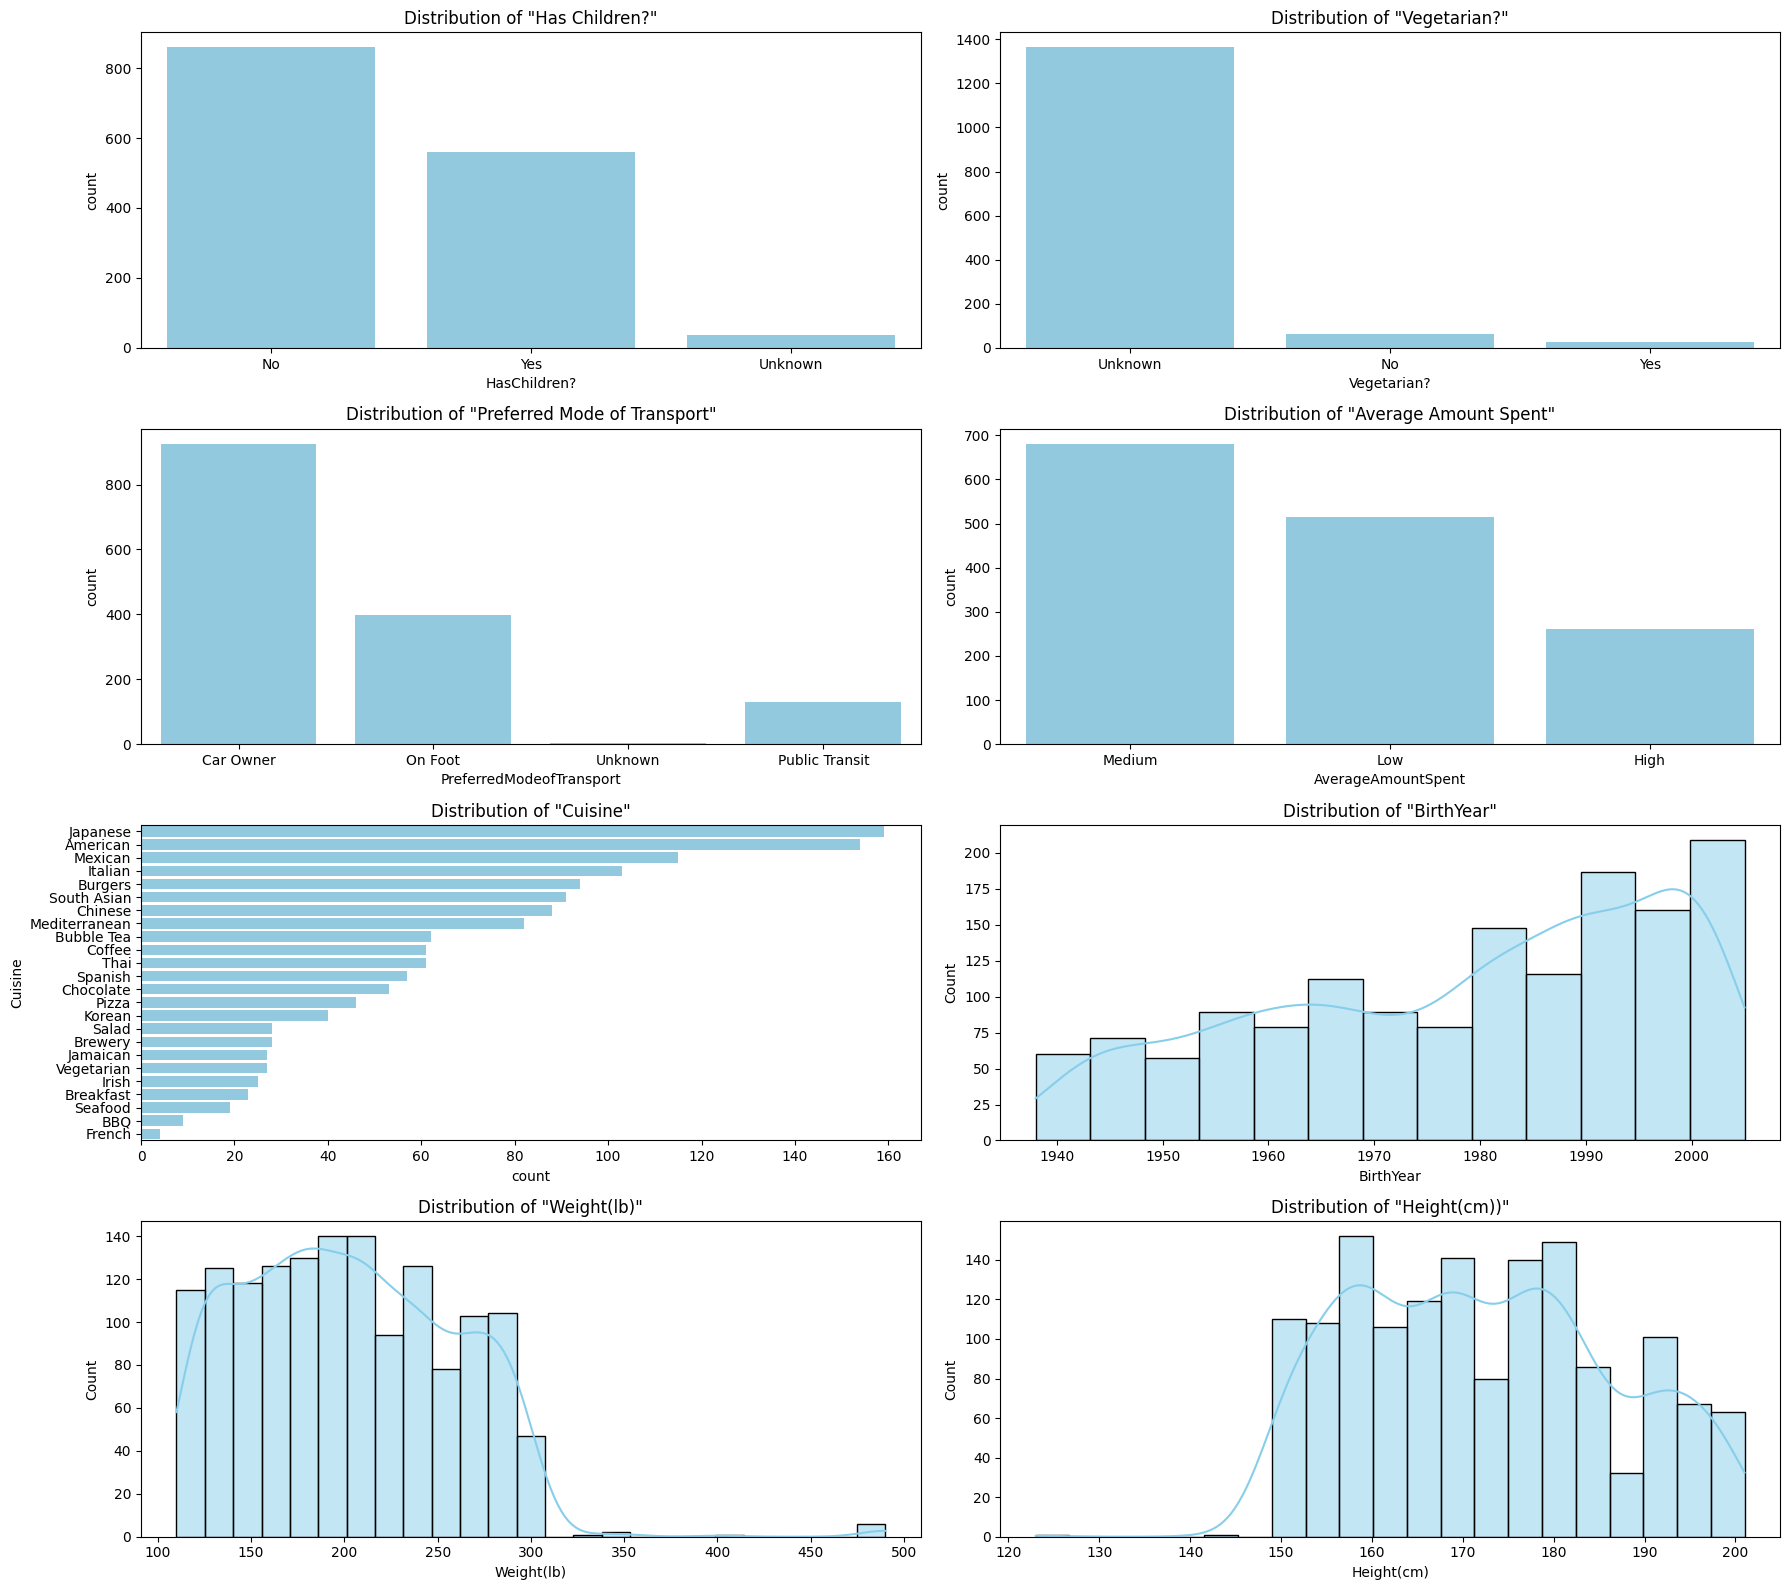

In [17]:

# Define the variables you want to plot
categorical_columns = ['HasChildren?', 'Vegetarian?', 'PreferredModeofTransport', 'AverageAmountSpent', 'Cuisine']
numerical_columns = ['BirthYear', 'Weight(lb)', 'Height(cm)']

# Set up the matplotlib figure
plt.figure(figsize=(18, 16))

# Subplot for 'HasChildren?'
plt.subplot(4, 2, 1)
sns.countplot(x='HasChildren?', data=Reviews, color='skyblue')
plt.title('Distribution of "Has Children?"')

# Subplot for 'Vegetarian?'
plt.subplot(4, 2, 2)
sns.countplot(x='Vegetarian?', data=Reviews, color='skyblue')
plt.title('Distribution of "Vegetarian?"')

# Subplot for 'PreferredModeofTransport'
plt.subplot(4, 2, 3)
sns.countplot(x='PreferredModeofTransport', data=Reviews, color='skyblue')
plt.title('Distribution of "Preferred Mode of Transport"')

# Subplot for 'AverageAmountSpent'
plt.subplot(4, 2, 4)
sns.countplot(x='AverageAmountSpent', data=Reviews, color='skyblue')
plt.title('Distribution of "Average Amount Spent"')

# Subplot for 'Cuisine'
plt.subplot(4, 2, 5)
sns.countplot(y='Cuisine', data=Reviews, order = Reviews['Cuisine'].value_counts().index, color='skyblue')
plt.title('Distribution of "Cuisine"')

# Subplot for 'BirthYear'
plt.subplot(4, 2, 6)
sns.histplot(Reviews['BirthYear'].dropna(), kde=True, color='skyblue')
plt.title('Distribution of "BirthYear"')

# Subplot for 'Weight(lb)'
plt.subplot(4, 2, 7)
sns.histplot(Reviews['Weight(lb)'], kde=True, color='skyblue')
plt.title('Distribution of "Weight(lb)"')

# Subplot for 'Height(cm)'
plt.subplot(4, 2, 8)
sns.histplot(Reviews['Height(cm)'], kde=True, color='skyblue')
plt.title('Distribution of "Height(cm))"')

# Adjust layout
plt.tight_layout()
plt.show()


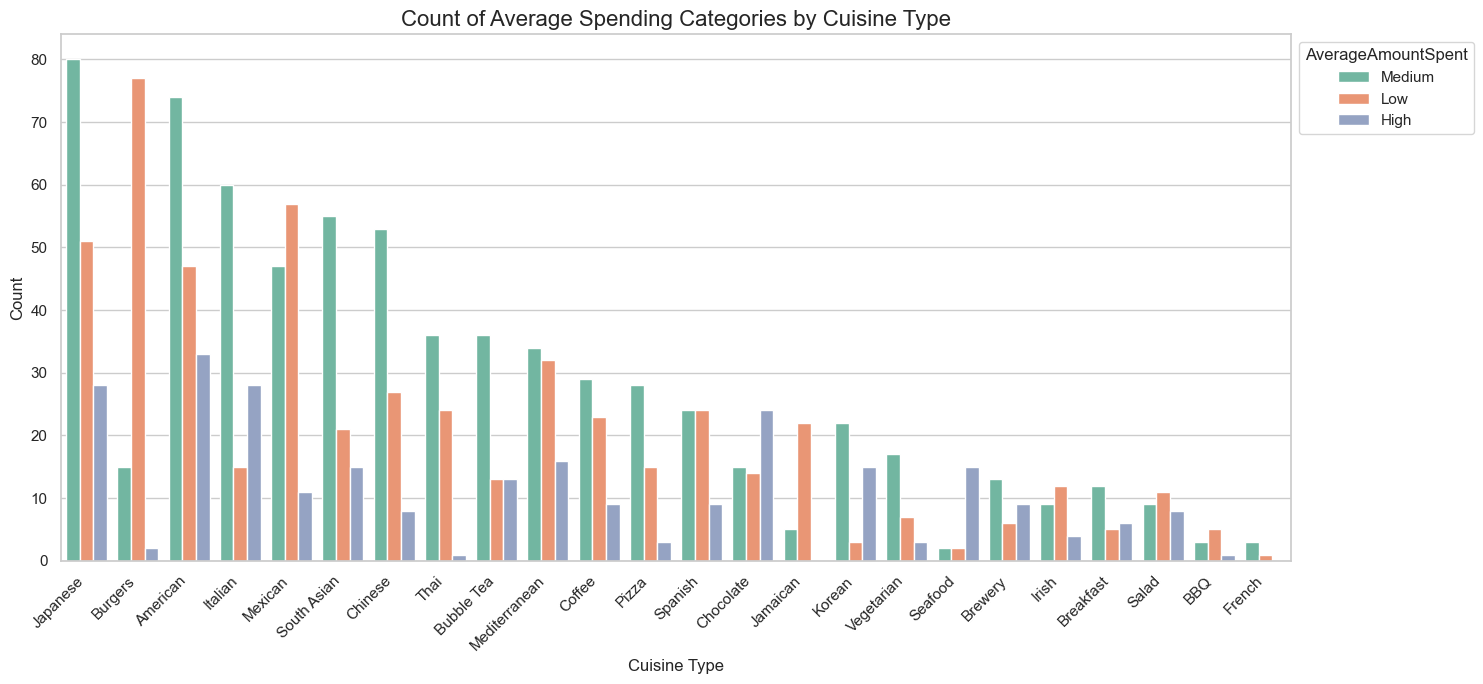

In [18]:
spending_order = Reviews.groupby('Cuisine')['AverageAmountSpent'].value_counts().unstack().fillna(0)
spending_order['MaxSpending'] = spending_order.max(axis=1)
sorted_cuisines = spending_order.sort_values('MaxSpending', ascending=False).index


sns.set(style="whitegrid")

plt.figure(figsize=(15, 7))

ax = sns.countplot(x='Cuisine', hue='AverageAmountSpent', data=Reviews, order=sorted_cuisines, palette='Set2')

ax.set_title('Count of Average Spending Categories by Cuisine Type', fontsize=16)
ax.set_xlabel('Cuisine Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

plt.xticks(rotation=45, ha='right')

plt.legend(title='AverageAmountSpent', bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()

plt.show()


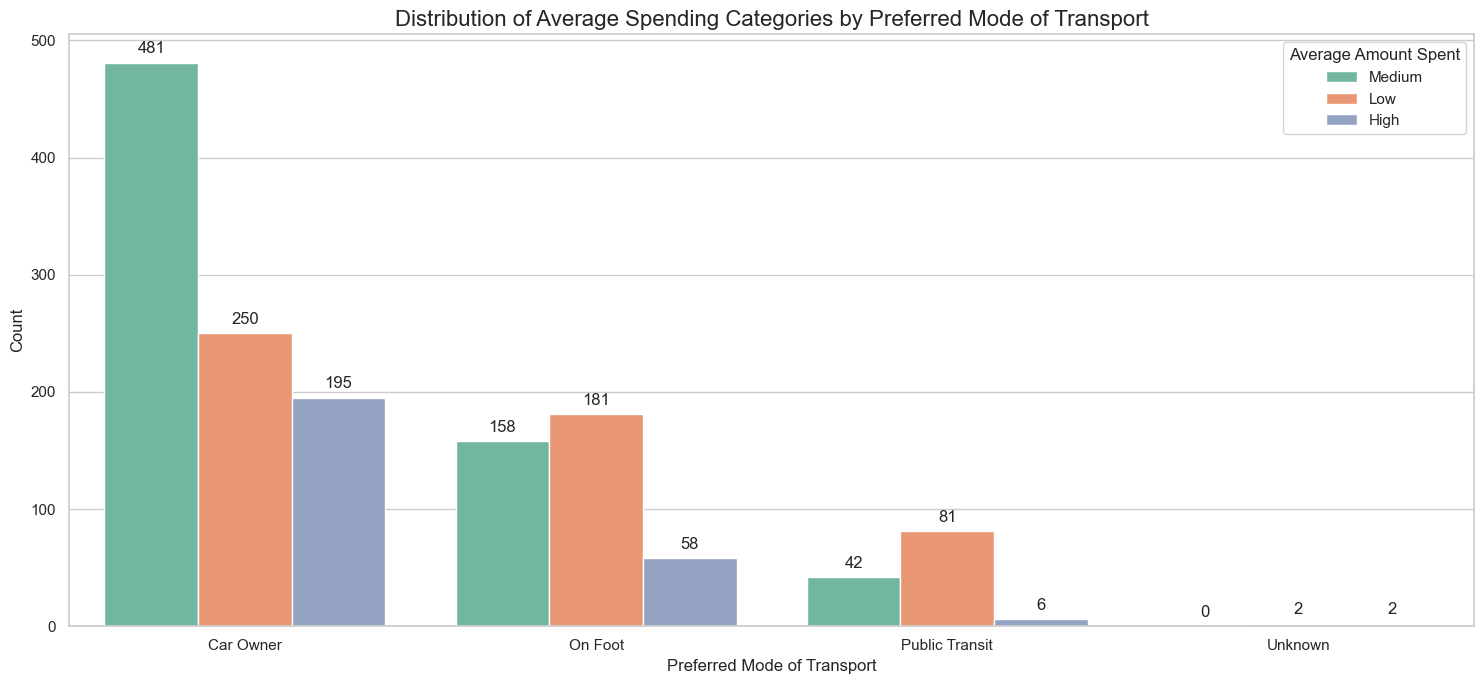

In [19]:
sns.set(style="whitegrid")

plt.figure(figsize=(15, 7))

ax = sns.countplot(
    x='PreferredModeofTransport',
    hue='AverageAmountSpent',
    data=Reviews,
    palette='Set2',
    order=['Car Owner', 'On Foot', 'Public Transit', 'Unknown']
)

ax.set_title('Distribution of Average Spending Categories by Preferred Mode of Transport', fontsize=16)
ax.set_xlabel('Preferred Mode of Transport', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.legend(title='Average Amount Spent', loc='upper right')
plt.tight_layout()

plt.show()

In [20]:
visit_counts = Reviews.groupby(['ReviewerName', 'RestaurantName']).size().reset_index(name='VisitFrequency')
print(visit_counts['VisitFrequency'].unique())

[ 1  2 14  4]


In [21]:
print(Reviews['RestaurantName'].unique())

['lao sze chuan' 'barn steakhouse' 'brothers k coffeehouse'
 'clarkes off campus' "edzo's burger shop" 'elephant & vine'
 'graduate homestead room' "panino's pizzeria" 'philz coffee' 'picnic'
 'epic burger' "dave's italian kitchen" 'nakorn' "steak n' shake"
 'pâtisserie coralie' 'leonidas cafe chocolaterie' 'chipotle'
 '5411 empanadas' "kuni's japanese restaurant" 'joy yee noodle'
 "hecky's bbq" 'taste of nepal' 'le peep' 'letour' 'table to stix ramen'
 'cross rhodes' 'peppercorns kitchen' 'shangri-la evanston'
 'mumbai indian grill' 'mt. everest restaurant' 'prairie moon'
 'kung fu tea' 'kansaku' 'sketchbook brewing co' 'hokkaido ramen'
 "kilwin's" 'zentli' "claire's korner" 'trattoria demi' 'trattoria doc'
 'jimmy johns' 'kabul house' 'rezas' 'oceanique' 'union pizzeria'
 'tealicious' 'cozy noodles and rice' 'tapas barcelona' 'campagnola'
 'soul & smoke' 'fridas' 'la principal' 'taco diablo' 'burger king'
 'tomo japanese street food' 'evanston chicken shack' 'papa bop'
 'fonda cantin

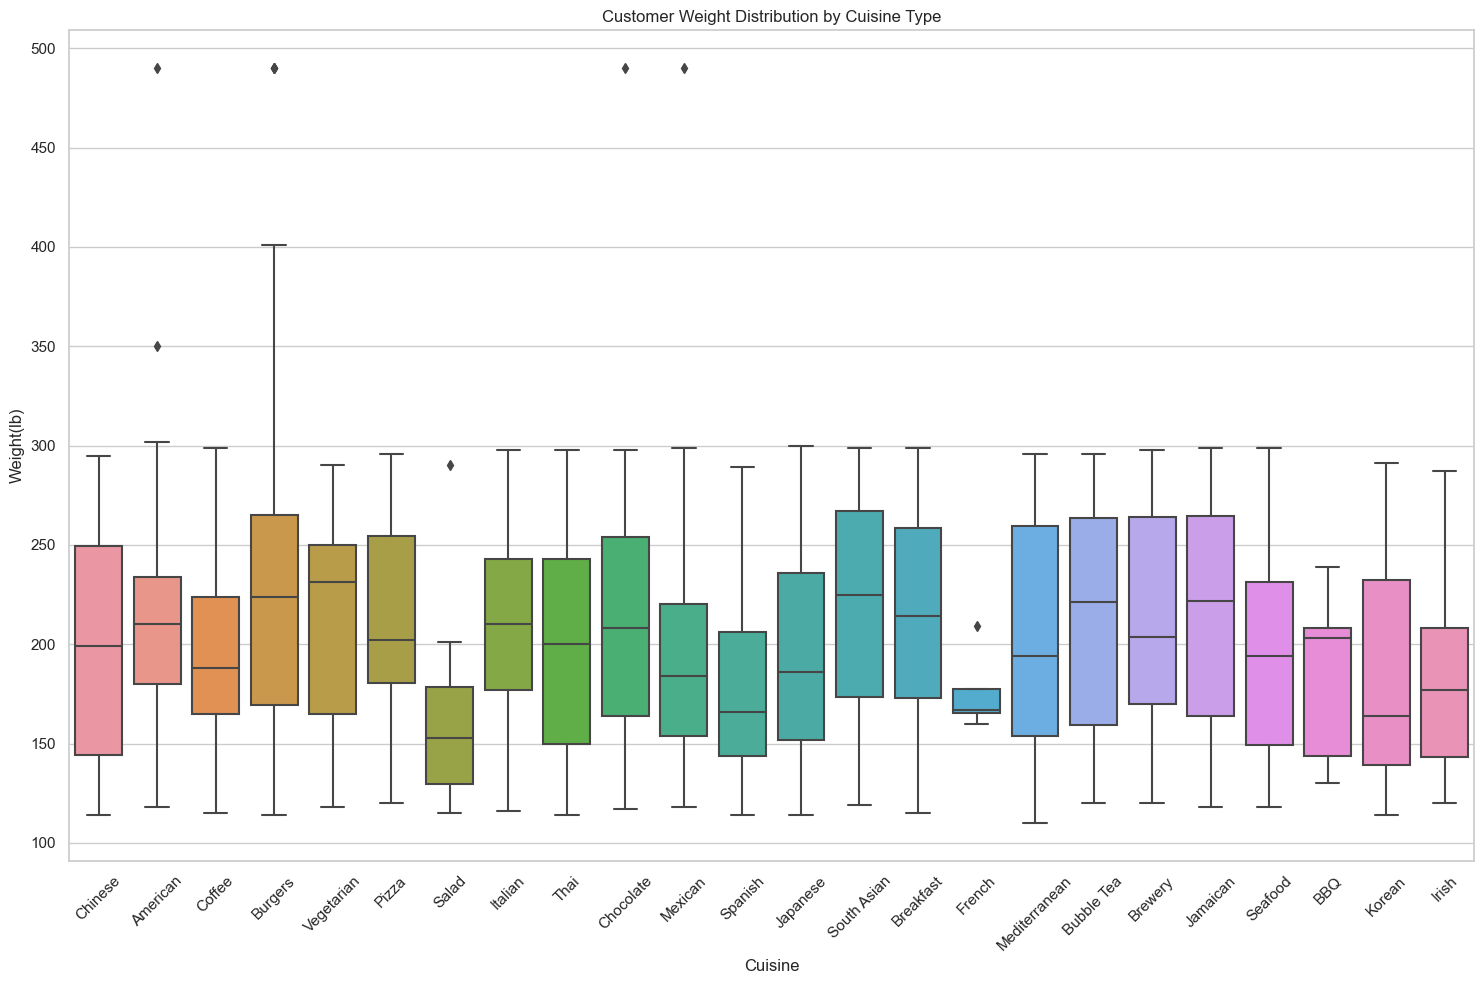

In [22]:
sns.set(style="whitegrid")

plt.figure(figsize=(15, 10))
sns.boxplot(x='Cuisine', y='Weight(lb)', data=Reviews)

plt.title('Customer Weight Distribution by Cuisine Type')

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()


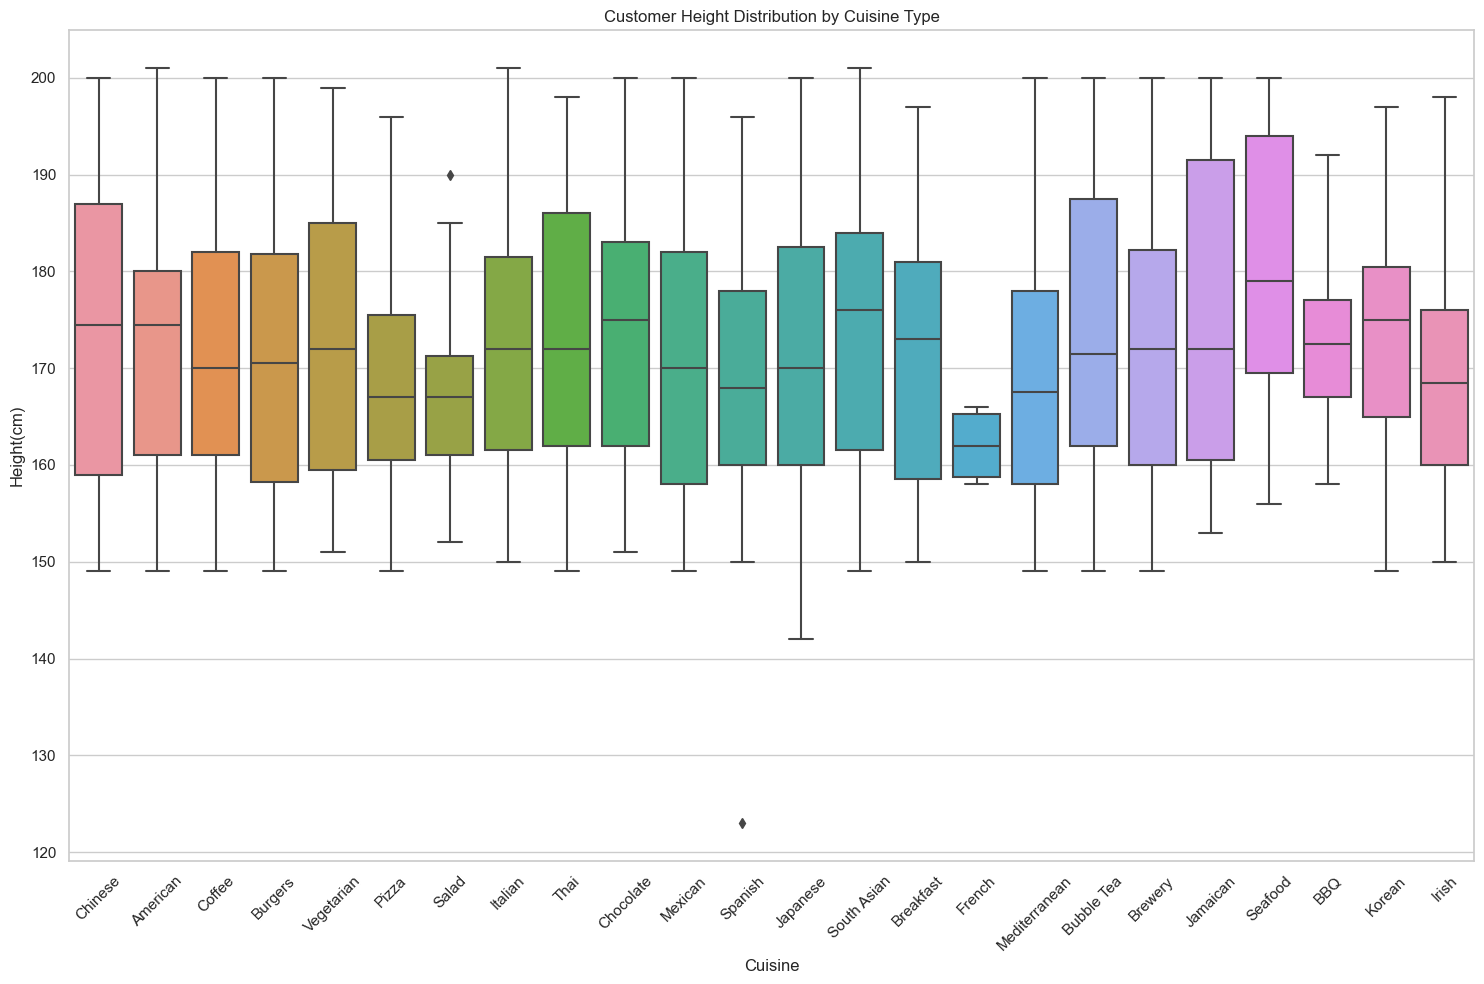

In [23]:
sns.set(style="whitegrid")

plt.figure(figsize=(15, 10))
sns.boxplot(x='Cuisine', y='Height(cm)', data=Reviews)

plt.title('Customer Height Distribution by Cuisine Type')

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

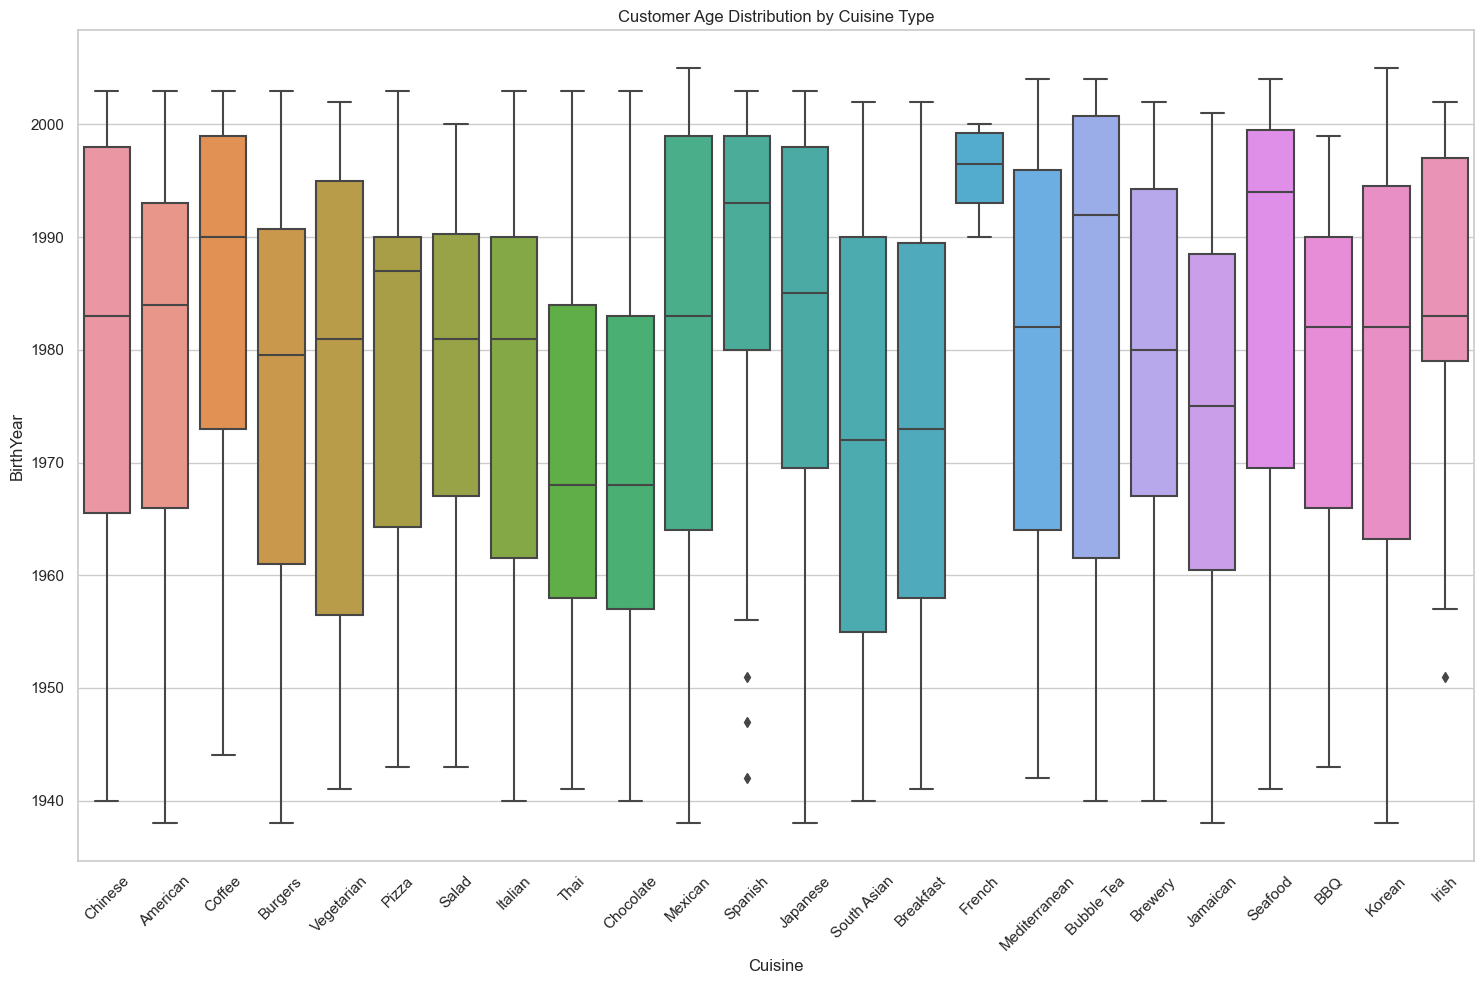

In [24]:
sns.set(style="whitegrid")

plt.figure(figsize=(15, 10))
sns.boxplot(x='Cuisine', y='BirthYear', data=Reviews)

plt.title('Customer Age Distribution by Cuisine Type')

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

# 3. clustering

## one-hot encode

In [25]:
# Preparing data for clustering - focusing on demographic data
demographic_data = Reviews[['MaritalStatus', 'HasChildren?', 'Vegetarian?', 'PreferredModeofTransport', 'NorthwesternStudent?']].copy()

# One-hot encoding the categorical data without specifying sparse
encoder = OneHotEncoder()
demographic_encoded = encoder.fit_transform(demographic_data).toarray()

# Create DataFrame with encoded data using get_feature_names_out()
columns = encoder.get_feature_names_out(demographic_data.columns)
demographic_encoded_df = pd.DataFrame(demographic_encoded, columns=columns)

# Display the first few rows of the reviews data with cluster labels
demographic_encoded_df.head()

,MaritalStatus_Unknown,MaritalStatus_married,MaritalStatus_single,MaritalStatus_widowed,HasChildren?_No,HasChildren?_Unknown,HasChildren?_Yes,Vegetarian?_No,Vegetarian?_Unknown,Vegetarian?_Yes,PreferredModeofTransport_Car Owner,PreferredModeofTransport_On Foot,PreferredModeofTransport_Public Transit,PreferredModeofTransport_Unknown,NorthwesternStudent?_No,NorthwesternStudent?_Yes
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## K-Mean Clustering

<function matplotlib.pyplot.show(close=None, block=None)>

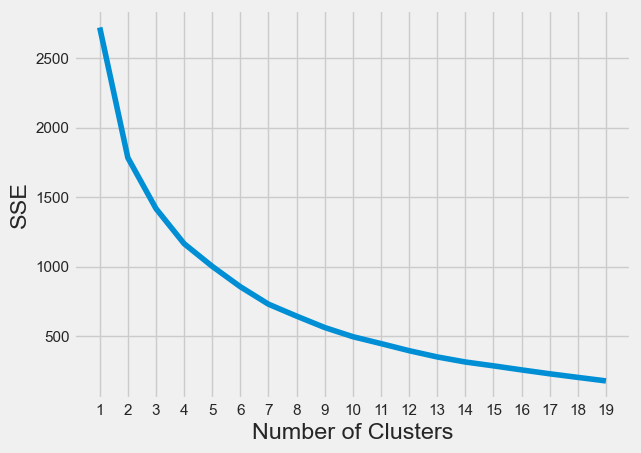

In [26]:
sse = []  # Within-cluster sum of square

# Loop through different numbers of clusters and save the within cluster sum of squares for each number
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init = 100, random_state=42)
    kmeans.fit(demographic_encoded_df)
    sse.append(kmeans.inertia_)

# Plot the Elbow Method result
plt.style.use('fivethirtyeight')
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show


#px.line(x=range(1, 20), y=sse, labels={'x': 'Number of Clusters', 'y': 'WCSS'}, title='Elbow Method', width = 800).show()

In [27]:
kl = KneeLocator(range(1, 20), sse, curve='convex', direction='decreasing')

print("Number of cluster:", kl.elbow)

Number of cluster: 6


In [28]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=kl.elbow, init='k-means++', n_init = 100, random_state=42)
clusters = kmeans.fit_predict(demographic_encoded_df)

# Add clusters back to the reviews data
Reviews['Cluster'] = clusters

# Calculate the average review score for each cluster
cluster_scores = Reviews.groupby('Cluster')['Rating'].mean()

# Count the number of reviews per cluster
cluster_counts = Reviews['Cluster'].value_counts()

# Combine the results into a single DataFrame for presentation
cluster_analysis = pd.DataFrame({
    'Average Rating': cluster_scores,
    'Review Count': cluster_counts
}).sort_index()


def most_common(series):
    return series.value_counts().idxmax()

cluster_analysis['MaritalStatus'] = Reviews.groupby('Cluster')['MaritalStatus'].agg(most_common)
cluster_analysis['HasChildren?'] = Reviews.groupby('Cluster')['HasChildren?'].agg(most_common)
cluster_analysis['Vegetarian?'] = Reviews.groupby('Cluster')['Vegetarian?'].agg(most_common)
cluster_analysis['PreferredModeofTransport'] = Reviews.groupby('Cluster')['PreferredModeofTransport'].agg(most_common)
cluster_analysis['NorthwesternStudent?'] = Reviews.groupby('Cluster')['NorthwesternStudent?'].agg(most_common)

cluster_analysis

,Average Rating,Review Count,MaritalStatus,HasChildren?,Vegetarian?,PreferredModeofTransport,NorthwesternStudent?
Cluster,,,,,,,
0,3.922747,233,married,No,Unknown,Car Owner,No
1,3.857143,224,single,No,Unknown,On Foot,No
2,3.544643,448,married,Yes,Unknown,Car Owner,No
3,3.841155,277,single,No,Unknown,Car Owner,No
4,3.478873,142,married,Yes,Unknown,On Foot,No
5,3.901515,132,single,No,Unknown,On Foot,Yes


In [29]:
# Silhouette Score
silhouette_kmeans = silhouette_score(demographic_encoded_df, Reviews['Cluster'])
print("K-Means Silhouette Score:", silhouette_kmeans)

K-Means Silhouette Score: 0.5603184209060342


## DBSCAN clustering

In [30]:
# DBSCAN clustering
dbscan = DBSCAN(eps=0.3)
clusters_dbscan = dbscan.fit_predict(demographic_encoded_df)
# Adding these clusters back to the reviews data for comparison
Reviews['Cluster_DBSCAN'] = clusters_dbscan

# Calculate the average review score and count reviews for DBSCAN
avg_rating_dbscan = Reviews.groupby('Cluster_DBSCAN')['Rating'].mean()
count_dbscan = Reviews['Cluster_DBSCAN'].value_counts()

# Combining results into DataFrames
cluster_dbscan = pd.DataFrame({'Average Rating': avg_rating_dbscan, 'Review Count': count_dbscan}).sort_index()

def most_common(series):
    return series.value_counts().idxmax()

cluster_dbscan['MaritalStatus'] = Reviews.groupby('Cluster_DBSCAN')['MaritalStatus'].agg(most_common)
cluster_dbscan['HasChildren?'] = Reviews.groupby('Cluster_DBSCAN')['HasChildren?'].agg(most_common)
cluster_dbscan['Vegetarian?'] = Reviews.groupby('Cluster_DBSCAN')['Vegetarian?'].agg(most_common)
cluster_dbscan['PreferredModeofTransport'] = Reviews.groupby('Cluster_DBSCAN')['PreferredModeofTransport'].agg(most_common)
cluster_dbscan['NorthwesternStudent?'] = Reviews.groupby('Cluster_DBSCAN')['NorthwesternStudent?'].agg(most_common)

cluster_dbscan

,Average Rating,Review Count,MaritalStatus,HasChildren?,Vegetarian?,PreferredModeofTransport,NorthwesternStudent?
Cluster_DBSCAN,,,,,,,
-1,4.057692,52,single,Yes,Unknown,Car Owner,No
0,3.880952,252,single,No,Unknown,Car Owner,No
1,3.949686,159,single,No,Unknown,On Foot,No
2,3.372093,43,single,No,Unknown,Public Transit,No
3,3.347222,72,married,Yes,Unknown,On Foot,No
4,3.740132,304,married,Yes,Unknown,Car Owner,No
5,3.620000,50,single,Yes,Unknown,Car Owner,No
6,3.864865,37,married,No,Unknown,On Foot,No
7,4.057692,156,married,No,Unknown,Car Owner,No


In [31]:
# Calculate the Silhouette Score
silhouette_dbscan = silhouette_score(demographic_encoded_df, Reviews['Cluster_DBSCAN'])
print(f'Silhouette Score for DBSCAN clustering: {silhouette_dbscan}')

Silhouette Score for DBSCAN clustering: 0.9498714636551254


## Agglomerative Clustering

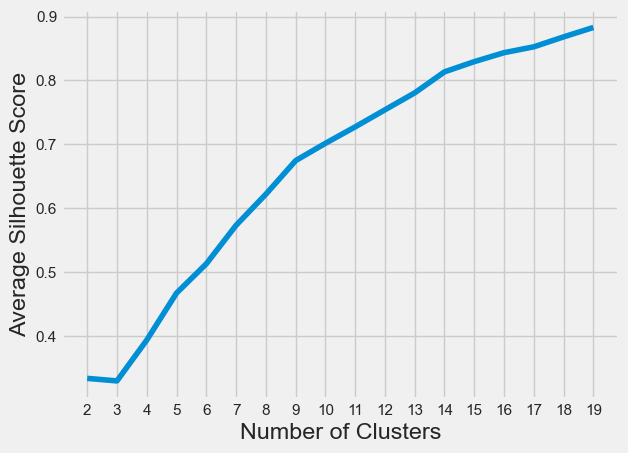

In [32]:
silhouette_avg_scores = []

for i in range(2, 20):  # silhouette score is not defined for a single cluster
    clusterer = AgglomerativeClustering(n_clusters=i)
    cluster_labels = clusterer.fit_predict(demographic_encoded_df)
    silhouette_avg = silhouette_score(demographic_encoded_df, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)

plt.style.use('fivethirtyeight')
plt.plot(range(2, 20), silhouette_avg_scores)  # Starting from 2 clusters
plt.xticks(range(2, 20))
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.show()

In [33]:
# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=15)
clusters_agglo = agglo.fit_predict(demographic_encoded_df)

# Adding these clusters back to the reviews data for comparison
Reviews['Cluster_Agglo'] = clusters_agglo

# Calculate the average review score and count reviews for Agglomerative Clustering
avg_rating_agglo = Reviews.groupby('Cluster_Agglo')['Rating'].mean()
count_agglo = Reviews['Cluster_Agglo'].value_counts()

# Combining results into DataFrames
cluster_analysis_agglo = pd.DataFrame({'Average Rating': avg_rating_agglo, 'Review Count': count_agglo}).sort_index()

def most_common(series):
    return series.value_counts().idxmax()

cluster_analysis_agglo['MaritalStatus'] = Reviews.groupby('Cluster_Agglo')['MaritalStatus'].agg(most_common)
cluster_analysis_agglo['HasChildren?'] = Reviews.groupby('Cluster_Agglo')['HasChildren?'].agg(most_common)
cluster_analysis_agglo['Vegetarian?'] = Reviews.groupby('Cluster_Agglo')['Vegetarian?'].agg(most_common)
cluster_analysis_agglo['PreferredModeofTransport'] = Reviews.groupby('Cluster_Agglo')['PreferredModeofTransport'].agg(most_common)
cluster_analysis_agglo['NorthwesternStudent?'] = Reviews.groupby('Cluster_Agglo')['NorthwesternStudent?'].agg(most_common)

cluster_analysis_agglo

,Average Rating,Review Count,MaritalStatus,HasChildren?,Vegetarian?,PreferredModeofTransport,NorthwesternStudent?
Cluster_Agglo,,,,,,,
0,3.875000,88,single,No,Unknown,On Foot,Yes
1,3.680556,72,single,Yes,Unknown,Car Owner,No
2,3.927273,55,single,No,Unknown,Car Owner,Yes
3,3.638298,47,married,Yes,Unknown,Public Transit,No
4,3.888889,45,married,No,No,Car Owner,No
5,3.434783,46,single,No,Unknown,Public Transit,No
6,2.593750,32,married,Yes,No,Car Owner,No
7,3.740132,304,married,Yes,Unknown,Car Owner,No
8,4.057692,156,married,No,Unknown,Car Owner,No


In [34]:
silhouette_agglo = silhouette_score(demographic_encoded_df, Reviews['Cluster_Agglo'])
silhouette_agglo

0.829387386514515

# 4. Base Rating

In [35]:
# Calculate the average review score for each restaurant
average_scores_per_restaurant = Reviews.groupby('RestaurantName')['Rating'].mean().reset_index()

# Find the restaurant with the highest average review score
highest_avg_score_restaurant = average_scores_per_restaurant[average_scores_per_restaurant['Rating'] == average_scores_per_restaurant['Rating'].max()]

# Calculate the overall average review score across all restaurants
overall_average_score = Reviews['Rating'].mean()

# Display the highest average score restaurant and the general average score
print(highest_avg_score_restaurant)
print("Overall average review score:", overall_average_score)

           RestaurantName  Rating
17  evanston games & cafe     5.0
18          fonda cantina     5.0
30           la principal     5.0
34                 letour     5.0
Overall average review score: 3.735576923076923


In [36]:
# Averge rating
res_avg_score = Reviews.groupby(['RestaurantName', 'Cuisine'])['Rating'].mean()
res_avg_score = res_avg_score.reset_index()
res_avg_score.columns = ['RestaurantName', 'Cuisine', 'Average_Rating']

# Review Count
res_count_review = Reviews.groupby('RestaurantName')['Rating'].count()
res_count_review = res_count_review.reset_index()
res_count_review.columns = ['RestaurantName', 'Count_Review']

# Combine and see outcome
popularity = pd.merge(left = res_avg_score, right = res_count_review, how = 'inner')
popularity

,RestaurantName,Cuisine,Average_Rating,Count_Review
0,5411 empanadas,Spanish,3.750000,28
1,alcove,American,3.631579,19
2,barn steakhouse,American,4.000000,15
3,brothers k coffeehouse,Coffee,4.533333,15
4,burger king,Burgers,1.800000,25
...,...,...,...,...
61,tomo japanese street food,Japanese,4.033333,30
62,trattoria demi,Italian,3.307692,13
63,trattoria doc,Italian,3.269231,26
64,union pizzeria,Pizza,4.212121,33


In [37]:
# Find highest average rating and most review counts
highest_avg_rating_index = popularity['Average_Rating'].idxmax()
highest_avg_rating_restaurant = popularity.loc[highest_avg_rating_index, ['RestaurantName', 'Average_Rating']]

most_count_review_index = popularity['Count_Review'].idxmax()
most_count_review_restaurant = popularity.loc[most_count_review_index, ['RestaurantName', 'Count_Review']]

print(f"Average Rating: {np.mean(Reviews['Rating'])}")
print(f"Restaurant with the highest average score: {highest_avg_rating_restaurant['RestaurantName']} ({highest_avg_rating_restaurant['Average_Rating']})")
print(f"Median number of reviews: {np.median(popularity['Count_Review'])}")
print(f"Restaurant with the most reviews: {most_count_review_restaurant['RestaurantName']} ({most_count_review_restaurant['Count_Review']})")

Average Rating: 3.735576923076923
Restaurant with the highest average score: evanston games & cafe (5.0)
Median number of reviews: 22.5
Restaurant with the most reviews: campagnola (48)


In [38]:
len(Reviews)

1456

# 5. Recommendation engine

In [39]:
# Create a cuisine list
cusine_list = []
for cuisine in popularity['Cuisine'].unique():
  cusine_list.append(cuisine)

# Recommed the restaurant base on cuisine
def recommend_restaurant(cuisine_type, popularity):
  # Filter restaurants by cuisine type
  basic_popularity = popularity.copy()
  basic_popularity['Cuisine'] = basic_popularity['Cuisine'].str.lower()
  cuisine_restaurants = basic_popularity[basic_popularity['Cuisine'] == cuisine_type]

  # Sort restaurants by average rating in descending order
  sorted_restaurants = cuisine_restaurants.sort_values(by=['Average_Rating', 'Count_Review'], ascending=[False, False])

  # Check if any restaurants are found for the specified cuisine type
  if not sorted_restaurants.empty:
    # Get the top 3 recommended restaurants
    top_recommendation = sorted_restaurants.iloc[:3][['RestaurantName', 'Average_Rating', 'Count_Review']]
    top_recommendation.reset_index(drop=True, inplace=True)
    return top_recommendation
  else:
    return "No restaurants found for the specified cuisine type."

Specific cuisine :
'Spanish', 'American', 'Coffee', 'Burgers', 'Italian', 'Irish', 'Mexican', 'Jamaican', 'Thai', 'Mediterranean', 'Vegetarian', 'Japanese', 
'Chinese', 'Chocolate', 'Bubble Tea', 'Breakfast', 'French', 'South Asian', 'Seafood', 'Pizza', 'Korean', 'Salad', 'Brewery', 'BBQ'

In [40]:
# Provides restaurant recommendations based on specific cuisine entered by the user
cuisine_type = input("Enter the cuisine type: ")
cuisine_type = cuisine_type.lower()

recommended_restaurant = recommend_restaurant(cuisine_type, popularity)
recommended_restaurant

'No restaurants found for the specified cuisine type.'

In [41]:
# Chinese restaurants
recommend_chinese_restaurant = recommend_restaurant('chinese', popularity)
# Mexican restaurants
recommend_mexican_restaurant = recommend_restaurant('mexican', popularity)
# Mpanish restaurants
recommend_spanish_restaurant = recommend_restaurant('spanish', popularity)
# Coffee shop
recommend_coffee_shop = recommend_restaurant('coffee', popularity)

print("Chinese restaurant recommendations")
print(recommend_chinese_restaurant, "\n")

print("Mexican restaurant recommendations")
print(recommend_mexican_restaurant, "\n")

print("Spanish restaurant recommendations")
print(recommend_spanish_restaurant, "\n")

print("Coffee recommendations")
print(recommend_coffee_shop, "\n")

Chinese restaurant recommendations
        RestaurantName  Average_Rating  Count_Review
0       joy yee noodle        4.290323            31
1  peppercorns kitchen        3.545455            33
2        lao sze chuan        3.291667            24 

Mexican restaurant recommendations
  RestaurantName  Average_Rating  Count_Review
0  fonda cantina        5.000000             6
1   la principal        5.000000             1
2         zentli        4.764706            17 

Spanish restaurant recommendations
    RestaurantName  Average_Rating  Count_Review
0  tapas barcelona        4.206897            29
1   5411 empanadas        3.750000            28 

Coffee recommendations
           RestaurantName  Average_Rating  Count_Review
0   evanston games & cafe        5.000000             1
1            philz coffee        4.600000            15
2  brothers k coffeehouse        4.533333            15 



# 6. Shrinkage estimator

In [42]:
popularity

,RestaurantName,Cuisine,Average_Rating,Count_Review
0,5411 empanadas,Spanish,3.750000,28
1,alcove,American,3.631579,19
2,barn steakhouse,American,4.000000,15
3,brothers k coffeehouse,Coffee,4.533333,15
4,burger king,Burgers,1.800000,25
...,...,...,...,...
61,tomo japanese street food,Japanese,4.033333,30
62,trattoria demi,Italian,3.307692,13
63,trattoria doc,Italian,3.269231,26
64,union pizzeria,Pizza,4.212121,33


In [43]:
# Define mu (mean rating) and N_mu (mean number of reviews)
mean_rating = np.mean(Reviews['Rating'])
mean_count = np.mean(popularity['Count_Review'])

# Calculate shrinkage estimator
popularity['Rating_New'] = (
    mean_count * mean_rating + popularity['Count_Review'] *
    popularity['Average_Rating']) / (
        popularity['Count_Review']  + mean_count)

# Sort by se
popularity_SE = popularity.sort_values(by=['Cuisine', 'Rating_New'], ascending=[False, True])
popularity_SE.reset_index(drop=True, inplace=True)

popularity_SE = popularity_SE[["RestaurantName", "Cuisine", "Rating_New", "Count_Review"]]

popularity_SE

,RestaurantName,Cuisine,Rating_New,Count_Review
0,elephant & vine,Vegetarian,3.860716,27
1,cozy noodles and rice,Thai,2.887235,38
2,nakorn,Thai,3.981506,23
3,5411 empanadas,Spanish,3.743644,28
4,tapas barcelona,Spanish,4.003264,29
...,...,...,...,...
61,prairie moon,American,3.648621,23
62,graduate homestead room,American,3.662098,10
63,alcove,American,3.687454,19
64,jimmy johns,American,3.753783,26


In [44]:
rating_change_df = pd.merge(
    popularity,
    popularity_SE[['RestaurantName', 'Rating_New']],
    on='RestaurantName',
    suffixes=('', '_SE')
)

# Calculate the change in rating
rating_change_df['Rating_Change'] = rating_change_df['Rating_New'] - rating_change_df['Average_Rating']

# Clean up the dataframe to have the desired column names
rating_change_df = rating_change_df[['RestaurantName', 'Cuisine', 'Average_Rating', 'Rating_New', 'Rating_Change']]

rating_change_sorted = rating_change_df.sort_values('Rating_Change', ascending=True)

rating_change_sorted

,RestaurantName,Cuisine,Average_Rating,Rating_New,Rating_Change
17,evanston games & cafe,Coffee,5.000000,3.790407,-1.209593
30,la principal,Mexican,5.000000,3.790407,-1.209593
34,letour,French,5.000000,3.929651,-1.070349
18,fonda cantina,Mexican,5.000000,4.005940,-0.994060
65,zentli,Mexican,4.764706,4.183476,-0.581230
...,...,...,...,...,...
36,mumbai indian grill,South Asian,2.807692,3.233607,0.425914
10,cozy noodles and rice,Thai,2.394737,2.887235,0.492498
11,cross rhodes,Mediterranean,2.750000,3.266931,0.516931
4,burger king,Burgers,1.800000,2.707341,0.907341


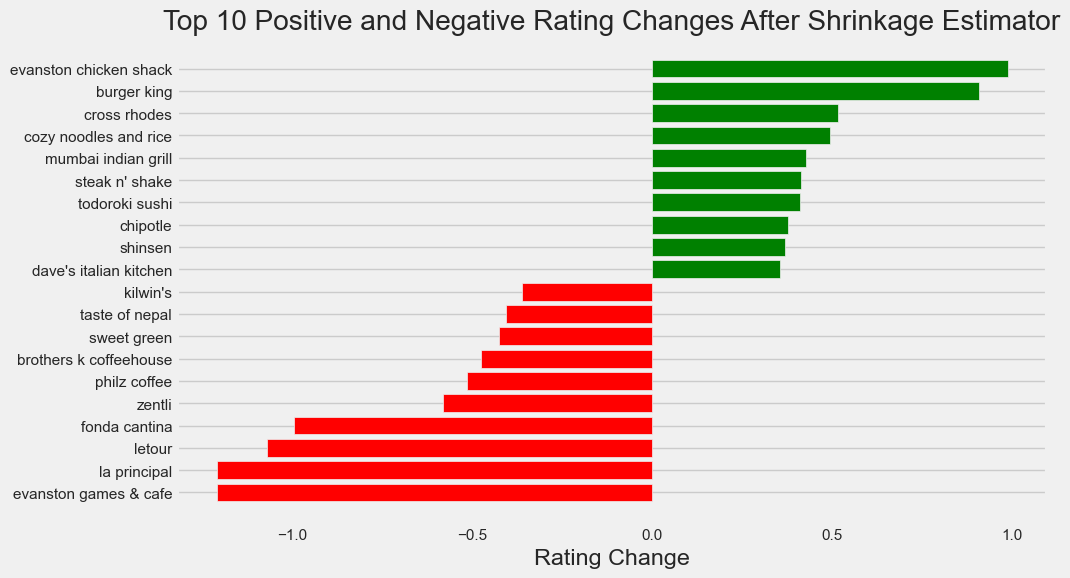

In [45]:
# Take top 3 positive and top 3 negative changes.
top_positive_changes = rating_change_sorted[-10:]
top_negative_changes = rating_change_sorted[:10]

# Concatenate both to have a dataframe with the 3 most positive and 3 most negative changes.
significant_changes = pd.concat([top_negative_changes, top_positive_changes])

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(significant_changes['RestaurantName'], significant_changes['Rating_Change'], color=['red' if x < 0 else 'green' for x in significant_changes['Rating_Change']])
plt.xlabel('Rating Change')
plt.title('Top 10 Positive and Negative Rating Changes After Shrinkage Estimator')
plt.grid(axis='x')

# Display the plot
plt.show()

# 7. Euclidean distance

In [46]:
Restaurants = Restaurants.replace(', -87.67915254400617', '-87.67915254400617')
Restaurants['Latitude'] = Restaurants['Latitude'].astype(float)
Restaurants['Longitude'] = Restaurants['Longitude'].astype(float)

categorical = ['Cuisine', 'OpenAfter8pm?']
numerical = ['Latitude', 'Longitude', 'AverageCost']

# One-hot encode categorical data
encoder = OneHotEncoder()
categorical_encoded = encoder.fit_transform(Restaurants[categorical])
categorical = encoder.get_feature_names_out(categorical)
categorical_encoded_df = pd.DataFrame(categorical_encoded.toarray(), columns=categorical)

# Scale numerical data
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(Restaurants[numerical])
numerical_scaled_df = pd.DataFrame(numerical_scaled, columns=numerical)

features = pd.concat([categorical_encoded_df, numerical_scaled_df], axis=1)

euclidean_distances = pdist(features, metric='euclidean')
euclidean_distances_df = pd.DataFrame(squareform(euclidean_distances), index=Restaurants['RestaurantName'], columns=Restaurants['RestaurantName'])

euclidean_distances_df

RestaurantName,tapas barcelona,lao sze chuan,5411 empanadas,hokkaido ramen,tomo japanese street food,kuni's japanese restaurant,kansaku,taco diablo,fridas,edzo's burger shop,...,cozy noodles and rice,nakorn,prairie moon,hecky's bbq,soban korea,burger king,sarah's brick oven,leonidas cafe chocolaterie,evanston games & cafe,shinsen
RestaurantName,,,,,,,,,,,,,,,,,,,,,
tapas barcelona,0.000000,1.436901,0.901314,1.715706,1.513754,2.297334,1.685079,1.642512,2.012810,2.177090,...,1.825582,1.669690,1.419061,2.423388,2.405842,2.695808,6.698969,3.984099,1.789176,1.566210
lao sze chuan,1.436901,0.000000,1.674422,1.685393,1.454145,2.500273,1.722088,1.629953,2.001687,2.194294,...,1.814869,1.659897,1.422432,2.323922,2.227106,2.732594,6.768830,3.798655,1.770242,1.683214
5411 empanadas,0.901314,1.674422,0.000000,1.427831,1.677232,2.535984,2.209152,1.722101,2.181416,2.009588,...,1.490893,2.194469,1.679770,2.420533,2.155146,2.341513,6.519024,3.844258,1.463303,1.813229
hokkaido ramen,1.715706,1.685393,1.427831,0.000000,0.857094,2.277698,1.735145,1.707117,2.191040,2.037692,...,1.475908,2.201590,1.708367,2.341984,2.028404,2.331552,6.516583,3.685124,1.445851,1.270939
tomo japanese street food,1.513754,1.454145,1.677232,0.857094,0.000000,2.262133,1.032278,1.541587,2.025255,2.225207,...,1.742573,1.668396,1.491717,2.171301,2.091191,2.592834,6.606349,3.528024,1.705480,1.095252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
burger king,2.695808,2.732594,2.341513,2.331552,2.592834,2.891772,2.821205,2.155203,3.021108,2.402536,...,2.012314,2.935656,2.743755,2.829618,3.203026,0.000000,4.808479,3.907251,2.101446,2.506624
sarah's brick oven,6.698969,6.768830,6.519024,6.516583,6.606349,6.197873,6.401595,6.027230,6.540647,6.415824,...,6.120294,6.601973,6.768578,6.136643,7.332793,4.808479,0.000000,6.582886,6.235356,6.322555
leonidas cafe chocolaterie,3.984099,3.798655,3.844258,3.685124,3.528024,5.359374,4.024451,3.534949,3.520896,3.749128,...,3.647006,3.840068,3.924474,2.535373,2.997793,3.907251,6.582886,0.000000,3.636800,4.368731


# 8. Cosine distance

In [47]:
cosine_similarities = cosine_similarity(features)
cosine_similarities_df = pd.DataFrame(cosine_similarities, index=Restaurants['RestaurantName'], columns=Restaurants['RestaurantName'])

cosine_similarities_df

RestaurantName,tapas barcelona,lao sze chuan,5411 empanadas,hokkaido ramen,tomo japanese street food,kuni's japanese restaurant,kansaku,taco diablo,fridas,edzo's burger shop,...,cozy noodles and rice,nakorn,prairie moon,hecky's bbq,soban korea,burger king,sarah's brick oven,leonidas cafe chocolaterie,evanston games & cafe,shinsen
RestaurantName,,,,,,,,,,,,,,,,,,,,,
tapas barcelona,1.000000,0.578824,0.846391,0.442691,0.523695,0.332132,0.461492,0.400983,0.154841,0.099982,...,0.351409,0.485112,0.589111,-0.042581,0.359395,0.006385,-0.387520,-0.117312,0.378708,0.500433
lao sze chuan,0.578824,1.000000,0.470550,0.469653,0.567568,0.202705,0.445162,0.420781,0.177562,0.098911,...,0.368322,0.497766,0.593546,0.055179,0.469559,-0.011151,-0.427428,0.022605,0.400579,0.431930
5411 empanadas,0.846391,0.470550,1.000000,0.639403,0.460064,0.208006,0.135254,0.396793,0.081582,0.285288,...,0.597347,0.165879,0.467029,0.027057,0.518147,0.299090,-0.220715,0.017874,0.612999,0.379764
hokkaido ramen,0.442691,0.469653,0.639403,1.000000,0.863453,0.374304,0.471905,0.415088,0.083703,0.272540,...,0.609585,0.168687,0.454909,0.097903,0.583069,0.309968,-0.214038,0.124111,0.626166,0.699816
tomo japanese street food,0.523695,0.567568,0.460064,0.863453,1.000000,0.353894,0.799738,0.471080,0.142107,0.057356,...,0.407825,0.484838,0.544803,0.163294,0.542989,0.083990,-0.322271,0.197995,0.434343,0.755190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
burger king,0.006385,-0.011151,0.299090,0.309968,0.083990,0.174042,-0.028635,0.365944,-0.270127,0.264798,...,0.489061,-0.097377,-0.020088,0.014652,0.071379,1.000000,0.649646,0.117894,0.439579,0.159250
sarah's brick oven,-0.387520,-0.427428,-0.220715,-0.214038,-0.322271,0.078129,-0.140781,0.062287,-0.277283,-0.149368,...,0.029365,-0.258498,-0.427424,0.041116,-0.418063,0.649646,1.000000,0.100424,-0.042387,-0.115250
leonidas cafe chocolaterie,-0.117312,0.022605,0.017874,0.124111,0.197995,-0.708679,-0.098580,0.176326,0.201773,0.083585,...,0.139781,0.034712,-0.065725,0.716662,0.539998,0.117894,0.100424,1.000000,0.147004,-0.398598


In [48]:
# See the distances from peppercornskitchen
euclidean_epic_peppercorns = euclidean_distances_df.loc['peppercorns kitchen', 'epic burger']
euclidean_laoszechuan_peppercorns = euclidean_distances_df.loc['peppercorns kitchen', 'lao sze chuan']
cosine_epic_peppercorns = cosine_similarities_df.loc['peppercorns kitchen', 'epic burger']
cosine_laoszechuan_peppercorns = cosine_similarities_df.loc['peppercorns kitchen', 'lao sze chuan']


print(f"Euclidean distance between 'Peppercorns Kitchen' and 'Epic Burger': {euclidean_epic_peppercorns}")
print(f"Cosine similarities between 'Peppercorns Kitchen' and 'Epic Burger': {cosine_epic_peppercorns} \n")

print(f"Euclidean distance between 'Peppercorns Kitchen' and 'Lao Sze Chuan': {euclidean_laoszechuan_peppercorns}")
print(f"Cosine similarities between 'Peppercorns Kitchen' and 'Lao Sze Chuan': {cosine_laoszechuan_peppercorns}")

Euclidean distance between 'Peppercorns Kitchen' and 'Epic Burger': 1.4362319734458955
Cosine similarities between 'Peppercorns Kitchen' and 'Epic Burger': 0.5283948126274441 

Euclidean distance between 'Peppercorns Kitchen' and 'Lao Sze Chuan': 0.3151110860116991
Cosine similarities between 'Peppercorns Kitchen' and 'Lao Sze Chuan': 0.9808416971881749


# 9. Willie Jacobsen

In [49]:
def content_based_recommendation(user_name, distances_df):
  # Find the favorite restaurant
  user_favorite_restaurant = Reviews[Reviews['ReviewerName'] == user_name].sort_values(by='Rating', ascending=False)['RestaurantName'].values[0]

  # Find most 10 similar restaurants
  similar_restaurants = distances_df.loc[user_favorite_restaurant].sort_values()

  top_10_recommendations = similar_restaurants.iloc[1:11]
  top_10_df = pd.DataFrame(top_10_recommendations.values, index=top_10_recommendations.index)
  top_10_df = top_10_recommendations.reset_index()

  if distances_df is euclidean_distances_df:
    top_10_df.columns = ['RestaurantName', 'Euclidean_Distances']
  else:
    top_10_df.columns = ['RestaurantName', 'Cosine_Distances']

  return top_10_df

# Make a top ten list for Willie Jacobsen
user_name = 'Willie Jacobsen'
user_favorite_restaurant = Reviews[Reviews['ReviewerName'] == user_name].sort_values(by='Rating', ascending=False)['RestaurantName'].values[0]
print(f"Willie Jacobsen's favorite restaurant is: {user_favorite_restaurant}")

top_10_df = content_based_recommendation(user_name, euclidean_distances_df)
top_10_df

Willie Jacobsen's favorite restaurant is: jimmy johns


,RestaurantName,Euclidean_Distances
0,clarkes off campus,0.930041
1,hecky's bbq,1.235294
2,edzo's burger shop,1.490472
3,pâtisserie coralie,1.502059
4,philz coffee,1.578572
5,evanston chicken shack,1.641670
6,le peep,1.656719
7,fridas,1.664978
8,prairie moon,1.695856
9,mumbai indian grill,2.000934


# 10.

In [50]:
cosine_distances = cosine_distances(features)
cosine_distances_df = pd.DataFrame(cosine_distances, index=Restaurants['RestaurantName'], columns=Restaurants['RestaurantName'])

cosine_distances_df

RestaurantName,tapas barcelona,lao sze chuan,5411 empanadas,hokkaido ramen,tomo japanese street food,kuni's japanese restaurant,kansaku,taco diablo,fridas,edzo's burger shop,...,cozy noodles and rice,nakorn,prairie moon,hecky's bbq,soban korea,burger king,sarah's brick oven,leonidas cafe chocolaterie,evanston games & cafe,shinsen
RestaurantName,,,,,,,,,,,,,,,,,,,,,
tapas barcelona,0.000000,0.421176,0.153609,0.557309,0.476305,0.667868,0.538508,0.599017,0.845159,0.900018,...,0.648591,0.514888,0.410889,1.042581,0.640605,0.993615,1.387520,1.117312,0.621292,0.499567
lao sze chuan,0.421176,0.000000,0.529450,0.530347,0.432432,0.797295,0.554838,0.579219,0.822438,0.901089,...,0.631678,0.502234,0.406454,0.944821,0.530441,1.011151,1.427428,0.977395,0.599421,0.568070
5411 empanadas,0.153609,0.529450,0.000000,0.360597,0.539936,0.791994,0.864746,0.603207,0.918418,0.714712,...,0.402653,0.834121,0.532971,0.972943,0.481853,0.700910,1.220715,0.982126,0.387001,0.620236
hokkaido ramen,0.557309,0.530347,0.360597,0.000000,0.136547,0.625696,0.528095,0.584912,0.916297,0.727460,...,0.390415,0.831313,0.545091,0.902097,0.416931,0.690032,1.214038,0.875889,0.373834,0.300184
tomo japanese street food,0.476305,0.432432,0.539936,0.136547,0.000000,0.646106,0.200262,0.528920,0.857893,0.942644,...,0.592175,0.515162,0.455197,0.836706,0.457011,0.916010,1.322271,0.802005,0.565657,0.244810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
burger king,0.993615,1.011151,0.700910,0.690032,0.916010,0.825958,1.028635,0.634056,1.270127,0.735202,...,0.510939,1.097377,1.020088,0.985348,0.928621,0.000000,0.350354,0.882106,0.560421,0.840750
sarah's brick oven,1.387520,1.427428,1.220715,1.214038,1.322271,0.921871,1.140781,0.937713,1.277283,1.149368,...,0.970635,1.258498,1.427424,0.958884,1.418063,0.350354,0.000000,0.899576,1.042387,1.115250
leonidas cafe chocolaterie,1.117312,0.977395,0.982126,0.875889,0.802005,1.708679,1.098580,0.823674,0.798227,0.916415,...,0.860219,0.965288,1.065725,0.283338,0.460002,0.882106,0.899576,0.000000,0.852996,1.398598


In [51]:
top_10_cosine_df = content_based_recommendation(user_name, cosine_distances_df)
top_10_cosine_df

,RestaurantName,Cosine_Distances
0,clarkes off campus,0.151715
1,hecky's bbq,0.241957
2,edzo's burger shop,0.374153
3,pâtisserie coralie,0.375907
4,evanston chicken shack,0.386070
5,philz coffee,0.427454
6,fridas,0.503699
7,le peep,0.512023
8,prairie moon,0.513950
9,soban korea,0.597142


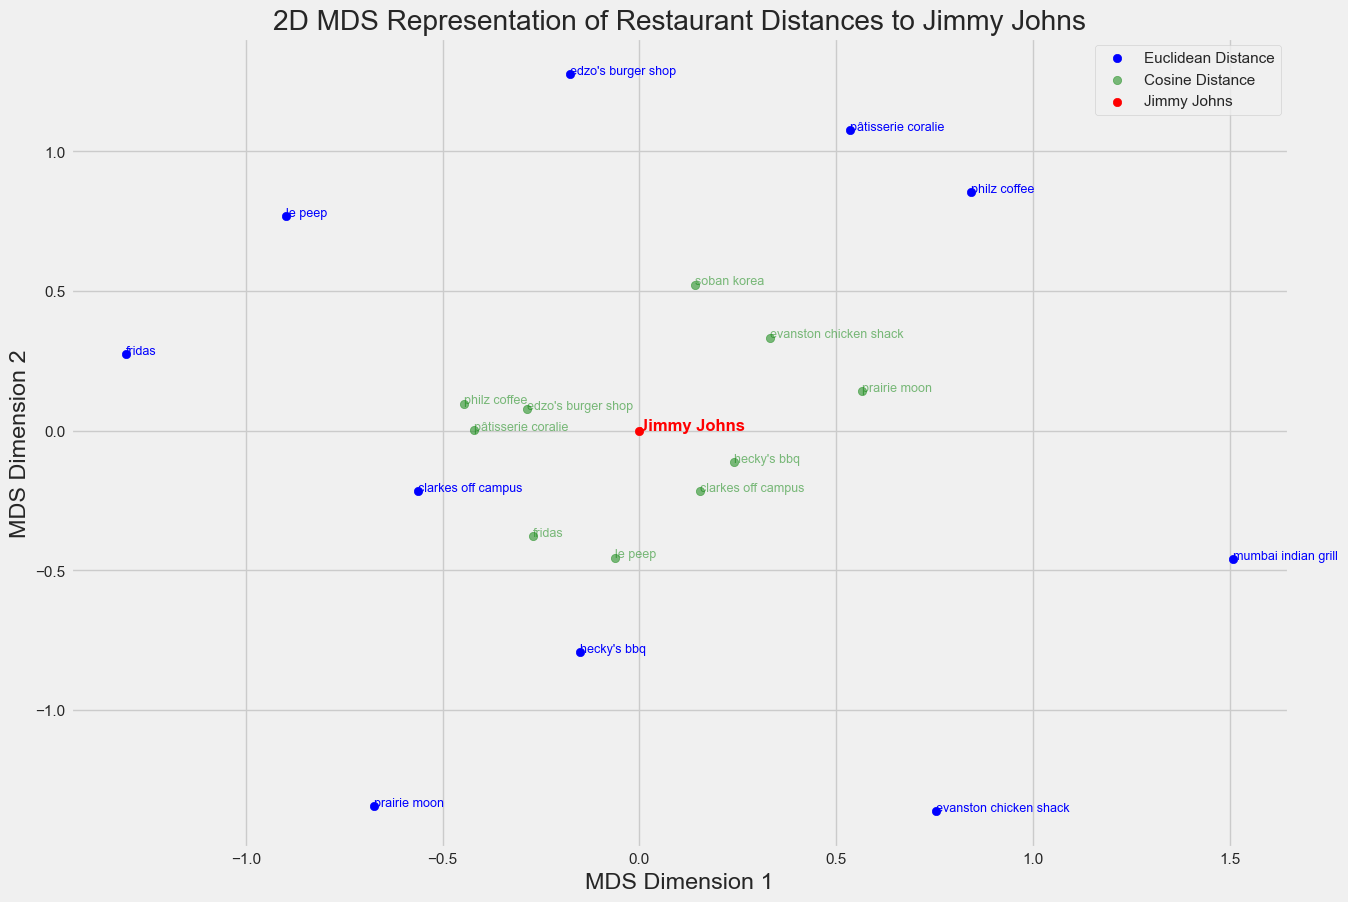

In [52]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# The two sets of restaurants
restaurants_euclidean = [
    'clarkes off campus', 'hecky\'s bbq', 'edzo\'s burger shop', 
    'pâtisserie coralie', 'philz coffee', 'evanston chicken shack', 
    'le peep', 'fridas', 'prairie moon', 'mumbai indian grill'
]

restaurants_cosine = [
    'clarkes off campus', 'hecky\'s bbq', 'edzo\'s burger shop', 
    'pâtisserie coralie', 'evanston chicken shack', 'philz coffee', 
    'fridas', 'le peep', 'prairie moon', 'soban korea'
]

# Perform MDS for the Euclidean distances
mds_euclidean = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
euclidean_matrix = euclidean_distances_df.loc[['jimmy johns'] + restaurants_euclidean, ['jimmy johns'] + restaurants_euclidean]
coordinates_euclidean = mds_euclidean.fit_transform(euclidean_matrix)

# Perform MDS for the Cosine distances
mds_cosine = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
cosine_matrix = cosine_distances_df.loc[['jimmy johns'] + restaurants_cosine, ['jimmy johns'] + restaurants_cosine]
coordinates_cosine = mds_cosine.fit_transform(cosine_matrix)

# Convert the results to DataFrames
coordinates_euclidean_df = pd.DataFrame(coordinates_euclidean, index=['jimmy johns'] + restaurants_euclidean, columns=['x', 'y'])
coordinates_cosine_df = pd.DataFrame(coordinates_cosine, index=['jimmy johns'] + restaurants_cosine, columns=['x', 'y'])

# Plotting
plt.figure(figsize=(14, 10))

euclidean_label = 'Euclidean Distance'
cosine_label = 'Cosine Distance'

# Plot Euclidean distances (only for the specified restaurants)
for restaurant in restaurants_euclidean:
    plt.scatter(
        coordinates_euclidean_df.loc[restaurant, 'x'], 
        coordinates_euclidean_df.loc[restaurant, 'y'], 
        color='blue', 
        label=euclidean_label if euclidean_label else None 
    )
    plt.text(
        coordinates_euclidean_df.loc[restaurant, 'x'], 
        coordinates_euclidean_df.loc[restaurant, 'y'], 
        restaurant, color='blue', fontsize=9
    )
    euclidean_label = None

for restaurant in restaurants_cosine:
    plt.scatter(
        coordinates_cosine_df.loc[restaurant, 'x'], 
        coordinates_cosine_df.loc[restaurant, 'y'], 
        color='green', 
        label=cosine_label if cosine_label else None,
        alpha=0.5
    )
    plt.text(
        coordinates_cosine_df.loc[restaurant, 'x'], 
        coordinates_cosine_df.loc[restaurant, 'y'], 
        restaurant, color='green', fontsize=9, alpha=0.5
    )
    cosine_label = None

# Adding Jimmy Johns point (only once)
jj_label = 'Jimmy Johns'
plt.scatter(
    0, 0, 
    color='red', 
    label=jj_label
)
plt.text(0, 0, 'Jimmy Johns', color='red', fontsize=12, weight='bold')

plt.legend()

plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('2D MDS Representation of Restaurant Distances to Jimmy Johns')
plt.grid(True)
plt.show()


# 11.

In [53]:
# Conact 'Brief Description' and 'Cuisine'
Restaurants['Augmented Description'] = Restaurants['BriefDescription'] + ' ' + Restaurants['Cuisine']

Restaurants['Augmented Description']

0     Festive, warm space known for Spanish small pl...
1     Modern Chinese mainstay, known for an extensiv...
2     Known for Argentinean empanadas & special sauc...
3     Whimsical ramen bar, known for sushi rolls and...
4     Japanese street food cafe with mobile app orde...
                            ...                        
59    Well-known fast-food chain known for grilled b...
60    Israeli cafe with Mediterranean and Italian in...
61    Known for fresh Belgian waffles, crepes & choc...
62    Board game cafe known for tournaments and coff...
63    BYOB spot for a variety of noodle dishes, sush...
Name: Augmented Description, Length: 64, dtype: object

# 12.

In [54]:
def Jaccard_Similarity(restaurant_one, restaurant_two):
  additional_punctuation = "，。！？【】（）：；“”‘’''""-—"

  # Find out first words list
  description_1 = Restaurants[Restaurants['RestaurantName'] == restaurant_one]['Augmented Description']
  description_1 = ''.join(description_1.tolist())
  words_1 = description_1.split()
  words_1 = [word.lower() for word in words_1 if word not in string.punctuation + additional_punctuation]
  words_1 = set(words_1)

  # Find out second words list
  description_2 = Restaurants[Restaurants['RestaurantName'] == restaurant_two]['Augmented Description']
  description_2 = ''.join(description_2.tolist())
  words_2 = description_2.split()
  words_2 = [word.lower() for word in words_2 if word not in string.punctuation + additional_punctuation]
  words_2 = set(words_2)

  # Find the intersection of words lists
  intersection = words_1.intersection(words_2)

  # Find the union of words lists
  union = words_1.union(words_2)

  # Calculate Jaccard similarity score
  return float(len(intersection)) / len(union)



In [55]:
# Jaccard distance between Burger King and Edzo's Burger Shop
restaurant_one = 'burger king'
restaurant_two = "edzo\'s burger shop"
burger_burger = Jaccard_Similarity(restaurant_one, restaurant_two)

# Jaccard distance between Burger King and Oceanique
restaurant_one = 'burger king'
restaurant_two = "oceanique"
burger_ocean = Jaccard_Similarity(restaurant_one, restaurant_two)

# Jaccard distance between Lao Sze Chuan and Kabul House
restaurant_one = 'lao sze chuan'
restaurant_two = "kabul house"
lao_kabul = Jaccard_Similarity(restaurant_one, restaurant_two)

# Show in df
jaccard_similarity = pd.DataFrame({
    'Restaurant_Pair': ['Burger King - Edzo\'s Burger Shop', 'Burger King - Oceanique', 'Lao Sze Chuan - Kabul House'],
    'Jaccard_Similarity': [burger_burger, burger_ocean, lao_kabul]
})


jaccard_similarity

,Restaurant_Pair,Jaccard_Similarity
0,Burger King - Edzo's Burger Shop,0.190476
1,Burger King - Oceanique,0.080000
2,Lao Sze Chuan - Kabul House,0.187500


# 13.

In [56]:
def recommend_restaurants(user_name):
  # Find the favorite restaurant of the user
  favorite_restaurant = Reviews[Reviews['ReviewerName'] == user_name].sort_values(by='Rating', ascending=False)['RestaurantName'].values[0]

  jaccard_list = []
  rest_list = []

  # For loop can help us calculate jaccard score one by one
  for rest in Restaurants['RestaurantName']:
    if rest == favorite_restaurant:
      continue # skip itself
    else:
      fav_other = Jaccard_Similarity(favorite_restaurant, rest)
      rest_list.append(rest)
      jaccard_list.append(fav_other)

  # Show top 5 recommendations in df
  fav_other_jacc = pd.DataFrame({'Restaurant_Name': rest_list, 'Jaccard_Similarity': jaccard_list})
  fav_other_jacc = fav_other_jacc.sort_values(by='Jaccard_Similarity', ascending=False).iloc[0:5]
  return fav_other_jacc


# Top 5 Recommendations for Calvin Smith
user_name = 'Calvin Smith'
print("Calvin Smith:")
print(recommend_restaurants(user_name), "\n")

# Top 5 Recommendations for Calvin Smith
user_name = 'Solomon M'
print("Solomon M:")
print(recommend_restaurants(user_name))

Calvin Smith:
        Restaurant_Name  Jaccard_Similarity
38               alcove            0.230769
47  shangri-la evanston            0.200000
39            oceanique            0.178571
21       union pizzeria            0.166667
6               kansaku            0.160000 

Solomon M:
               Restaurant_Name  Jaccard_Similarity
3    tomo japanese street food            0.238095
4   kuni's japanese restaurant            0.208333
36                  tealicious            0.190476
61       evanston games & cafe            0.176471
34               fonda cantina            0.176471
